Energy Efficiency Dataset

In this notebook, we explore how building design parameters affect energy efficiency. We’ll clean the data, inspect relationships, build baseline and improved models for HeatingLoad (Y1) and CoolingLoad (Y2), and interpret which features matter most.

In [19]:
# Install deps into the current kernel
%pip install -q --progress-bar off -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [20]:
import math, warnings
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

import xgboost as xgb
HAS_XGB = True
print("xgboost:", xgb.__version__)

xgboost: 3.0.5


In [21]:
# ── Data load & tidy ───────────────────────────────────────────────────────────
DATA_PATH = "ENB2012_data.csv"
df = pd.read_csv(DATA_PATH)

rename_map = {
    "X1": "RelativeCompactness",
    "X2": "SurfaceArea",
    "X3": "WallArea",
    "X4": "RoofArea",
    "X5": "OverallHeight",
    "X6": "Orientation",
    "X7": "GlazingArea",
    "X8": "GlazingAreaDistribution",
    "Y1": "HeatingLoad",
    "Y2": "CoolingLoad"
}
df.rename(columns={c: rename_map.get(c, c) for c in df.columns}, inplace=True)

feature_cols = [
    "RelativeCompactness","SurfaceArea","WallArea","RoofArea",
    "OverallHeight","Orientation","GlazingArea","GlazingAreaDistribution"
]
target_cols = ["HeatingLoad","CoolingLoad"]

print("\nMissing values per column:")
print(df.isnull().sum())

print(f"\nDuplicate rows: {df.duplicated().sum()}")

print("\nDescriptive statistics (numeric):")
display(df.select_dtypes(include="number").describe().T)



Missing values per column:
RelativeCompactness        0
SurfaceArea                0
WallArea                   0
RoofArea                   0
OverallHeight              0
Orientation                0
GlazingArea                0
GlazingAreaDistribution    0
HeatingLoad                0
CoolingLoad                0
dtype: int64

Duplicate rows: 0

Descriptive statistics (numeric):


,count,mean,std,min,25%,50%,75%,max
RelativeCompactness,768.0,0.764167,0.105777,0.62,0.6825,0.75,0.8300,0.98
SurfaceArea,768.0,671.708333,88.086116,514.50,606.3750,673.75,741.1250,808.50
WallArea,768.0,318.500000,43.626481,245.00,294.0000,318.50,343.0000,416.50
RoofArea,768.0,176.604167,45.165950,110.25,140.8750,183.75,220.5000,220.50
OverallHeight,768.0,5.250000,1.751140,3.50,3.5000,5.25,7.0000,7.00
Orientation,768.0,3.500000,1.118763,2.00,2.7500,3.50,4.2500,5.00
GlazingArea,768.0,0.234375,0.133221,0.00,0.1000,0.25,0.4000,0.40
GlazingAreaDistribution,768.0,2.812500,1.550960,0.00,1.7500,3.00,4.0000,5.00
HeatingLoad,768.0,22.307201,10.090196,6.01,12.9925,18.95,31.6675,43.10
CoolingLoad,768.0,24.587760,9.513306,10.90,15.6200,22.08,33.1325,48.03


Interpretation: This dataset is typically clean (no NaNs/dupes). Targets are continuous (regression).

EDA: outliers & correlations

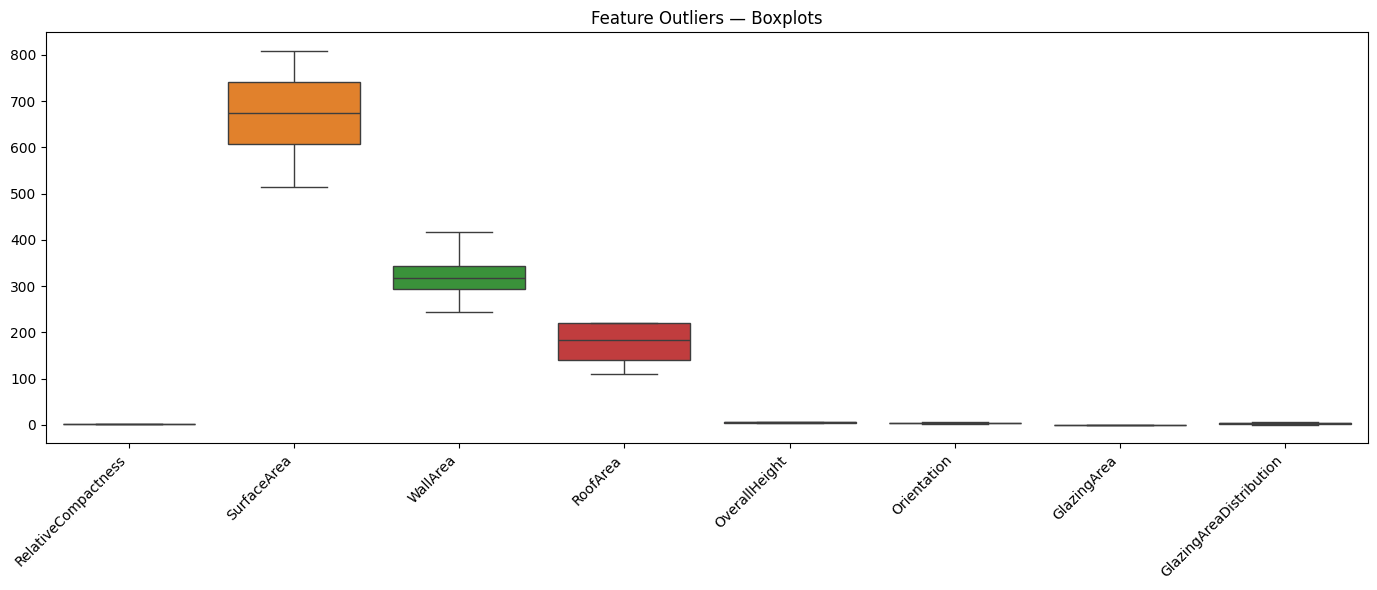

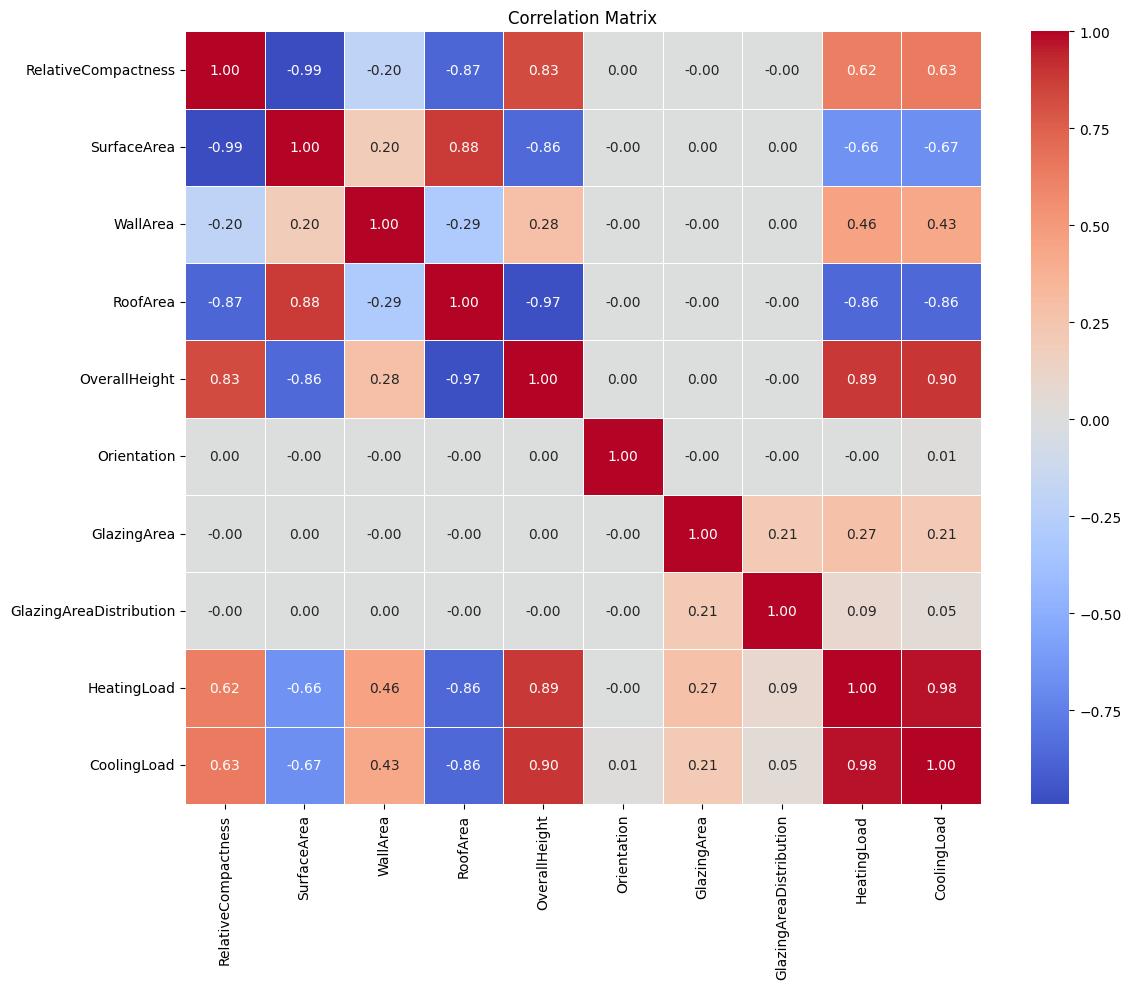


Feature vs Target correlations (sorted by HeatingLoad):


,HeatingLoad,CoolingLoad
OverallHeight,0.889431,0.895785
RelativeCompactness,0.622272,0.634339
WallArea,0.455671,0.427117
GlazingArea,0.269841,0.207505
GlazingAreaDistribution,0.087368,0.050525
Orientation,-0.002587,0.014290
SurfaceArea,-0.658120,-0.672999
RoofArea,-0.861828,-0.862547


HeatingLoad vs CoolingLoad correlation: 0.9758618134328587


In [22]:
# Boxplots: all features on one axes (easier to scan)
plt.figure(figsize=(14,6))
sns.boxplot(data=df[feature_cols], orient='v', showfliers=True)
plt.title("Feature Outliers — Boxplots")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

# Correlations
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix"); plt.tight_layout(); plt.show()

feat_target_corr = corr.loc[feature_cols, target_cols].sort_values(by="HeatingLoad", ascending=False)
print("\nFeature vs Target correlations (sorted by HeatingLoad):")
display(feat_target_corr)

print("HeatingLoad vs CoolingLoad correlation:", float(corr.loc["HeatingLoad","CoolingLoad"]))


Interpretation: Heating and Cooling loads are usually strongly correlated. Features like RelativeCompactness and OverallHeight tend to be influential.

Train/test split

In [23]:
X = df[feature_cols].copy()
Y = df[target_cols].copy()

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
y_h_train, y_h_test = Y_train["HeatingLoad"], Y_test["HeatingLoad"]
y_c_train, y_c_test = Y_train["CoolingLoad"], Y_test["CoolingLoad"]

Helpers (metrics + quick plot)

In [24]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def evaluate(y_true, y_pred, label=""):
    return {"Label": label, "R2": r2_score(y_true, y_pred),
            "RMSE": rmse(y_true, y_pred), "MAE": mean_absolute_error(y_true, y_pred)}

def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=20, alpha=0.7)
    lo, hi = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([lo,hi],[lo,hi],"--")
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(title)
    plt.tight_layout(); plt.show()


Baseline models (simple numeric encoding)

We treat Orientation and GlazingAreaDistribution as numeric for this baseline.

,Label,R2,RMSE,MAE
0,Linear (Y1),0.912184,3.025424,2.182047
1,RF (Y1),0.997700,0.489673,0.352324
2,Linear (Y2),0.893226,3.145382,2.195295
3,RF (Y2),0.966920,1.750736,1.079107


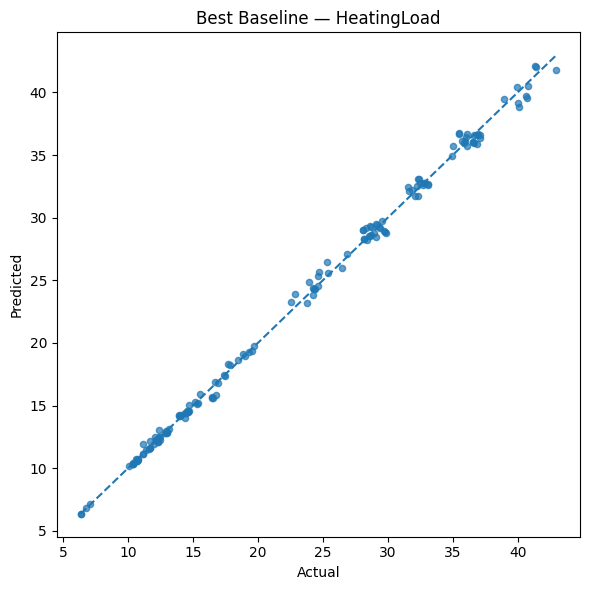

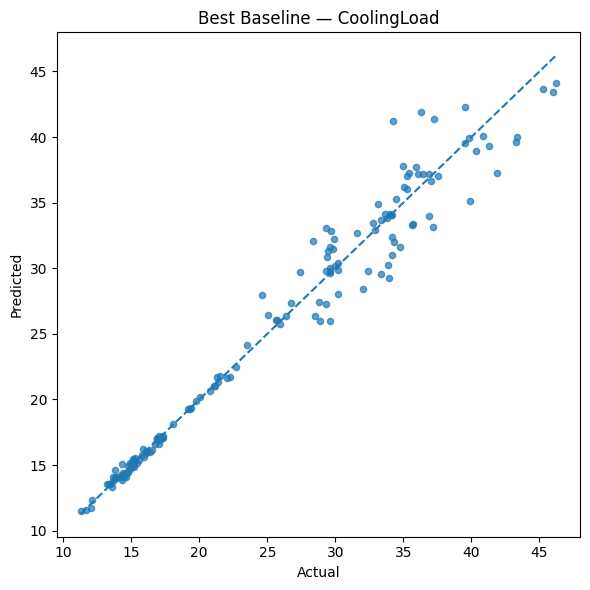

In [25]:
# Linear (with scaling)
lin_h = Pipeline([("scaler", StandardScaler()), ("linreg", LinearRegression())]).fit(X_train, y_h_train)
lin_c = Pipeline([("scaler", StandardScaler()), ("linreg", LinearRegression())]).fit(X_train, y_c_train)

# Random Forest (no scaling needed)
rf_h = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1).fit(X_train, y_h_train)
rf_c = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1).fit(X_train, y_c_train)

rows = []
for name, model, y_true in [
    ("Linear (Y1)", lin_h, y_h_test), ("RF (Y1)", rf_h, y_h_test),
    ("Linear (Y2)", lin_c, y_c_test), ("RF (Y2)", rf_c, y_c_test)
]:
    yhat = model.predict(X_test)
    rows.append(evaluate(y_true, yhat, name))

metrics_baseline = pd.DataFrame(rows)
display(metrics_baseline)

# Quick plots for the better model in each target
y1_best = rf_h if metrics_baseline.query("Label=='RF (Y1)'").R2.item() >= metrics_baseline.query("Label=='Linear (Y1)'").R2.item() else lin_h
y2_best = rf_c if metrics_baseline.query("Label=='RF (Y2)'").R2.item() >= metrics_baseline.query("Label=='Linear (Y2)'").R2.item() else lin_c

plot_predictions(y_h_test, y1_best.predict(X_test), "Best Baseline — HeatingLoad")
plot_predictions(y_c_test, y2_best.predict(X_test), "Best Baseline — CoolingLoad")


Random Forest clearly outperforms Linear on both targets (R² ≈ 0.998 vs 0.91 for Y1, and 0.967 vs 0.893 for Y2). This tells us there are meaningful nonlinearities/interactions the linear model can’t capture. The error scale drops a lot (RMSE from ~3.0 to ~0.49 for Y1, ~3.15 to ~1.75 for Y2), which is a practical win.
Since RF wins, nonlinearity/interaction effects matter.

Better encoding: treat categoricals properly
Orientation and GlazingAreaDistribution are categorical codes. One-hot often boosts linear models and can help tree models a bit too.

In [26]:
cat_features = ["Orientation", "GlazingAreaDistribution"]
num_features = [c for c in feature_cols if c not in cat_features]

preprocess_lin = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop"
)

preprocess_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop"
)

pipe_lin_y1 = Pipeline([("prep", preprocess_lin), ("model", Ridge(alpha=1.0))]).fit(X_train, y_h_train)
pipe_lin_y2 = Pipeline([("prep", preprocess_lin), ("model", Ridge(alpha=1.0))]).fit(X_train, y_c_train)

pipe_rf_y1  = Pipeline([("prep", preprocess_tree), ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))]).fit(X_train, y_h_train)
pipe_rf_y2  = Pipeline([("prep", preprocess_tree), ("model", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))]).fit(X_train, y_c_train)

rows = []
for name, model, y_true in [
    ("Ridge+OHE (Y1)", pipe_lin_y1, y_h_test), ("RF+OHE (Y1)", pipe_rf_y1, y_h_test),
    ("Ridge+OHE (Y2)", pipe_lin_y2, y_c_test), ("RF+OHE (Y2)", pipe_rf_y2, y_c_test),
]:
    rows.append(evaluate(y_true, model.predict(X_test), name))

metrics_ohe = pd.DataFrame(rows)
display(metrics_ohe)


,Label,R2,RMSE,MAE
0,Ridge+OHE (Y1),0.920121,2.885460,2.074354
1,RF+OHE (Y1),0.997297,0.530776,0.365395
2,Ridge+OHE (Y2),0.894377,3.128371,2.185015
3,RF+OHE (Y2),0.955107,2.039528,1.271176


One-hot encoding slightly improves the linear model (Ridge+OHE ≈ 0.92/0.89 R²), but RF+OHE doesn’t beat plain RF here (Y1: ~0.997 vs ~0.998; Y2: ~0.955 vs ~0.967). Trees already handle these integer-coded categories fairly well, so OHE helps linear models more than trees in this dataset.

Which features matter? (Permutation importance)

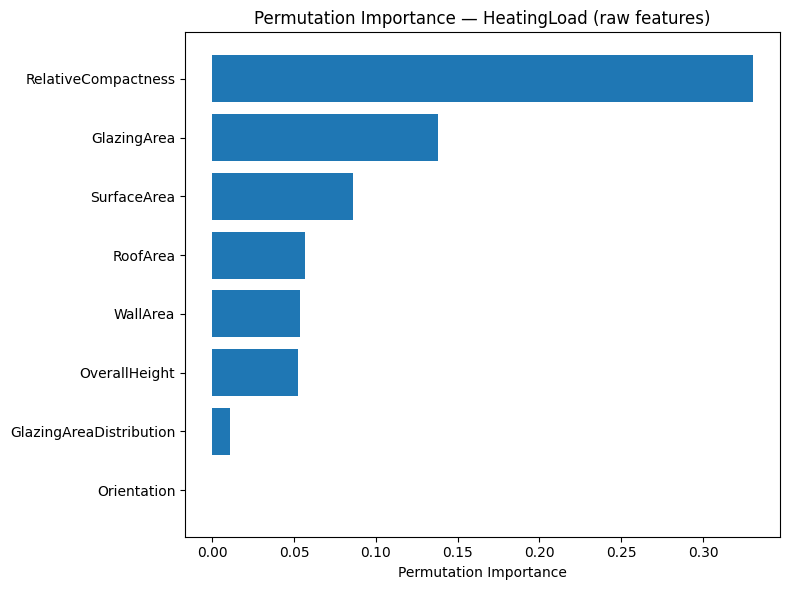

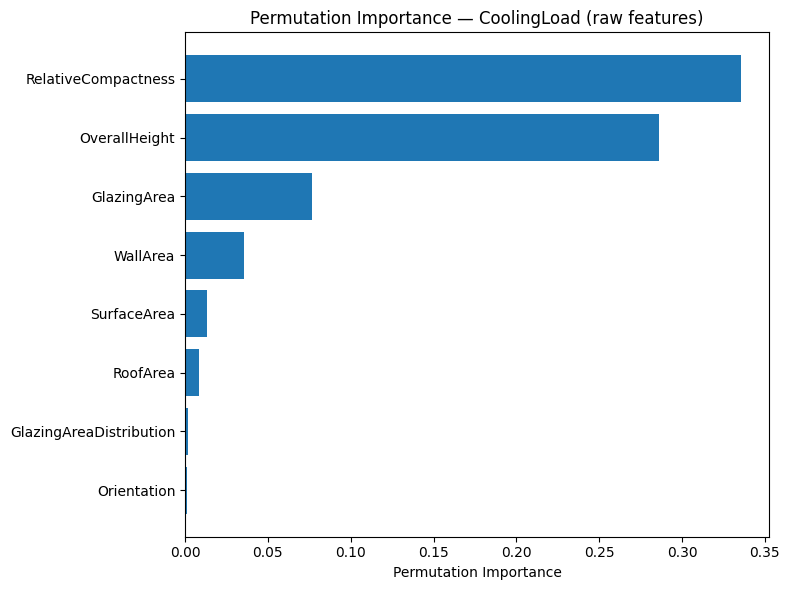

In [27]:
# === Permutation importance on RAW features (simplest) ===
best_y1 = pipe_rf_y1 if metrics_ohe.query("Label=='RF+OHE (Y1)'").R2.item() >= metrics_ohe.query("Label=='Ridge+OHE (Y1)'").R2.item() else pipe_lin_y1
best_y2 = pipe_rf_y2 if metrics_ohe.query("Label=='RF+OHE (Y2)'").R2.item() >= metrics_ohe.query("Label=='Ridge+OHE (Y2)'").R2.item() else pipe_lin_y2

perm_y1 = permutation_importance(best_y1, X_test, y_h_test, n_repeats=10, random_state=42)
perm_y2 = permutation_importance(best_y2, X_test, y_c_test, n_repeats=10, random_state=42)

def plot_perm_simple(names, importances, title):
    idx = np.argsort(importances.importances_mean)
    plt.figure(figsize=(8,6))
    plt.barh(np.array(names)[idx], importances.importances_mean[idx])
    plt.title(title); plt.xlabel("Permutation Importance")
    plt.tight_layout(); plt.show()

plot_perm_simple(feature_cols, perm_y1, "Permutation Importance — HeatingLoad (raw features)")
plot_perm_simple(feature_cols, perm_y2, "Permutation Importance — CoolingLoad (raw features)")


Feature importance: We permuted inputs to measure their effect on error. Larger drops in performance indicate more influential variables. Results highlight RelativeCompactness, OverallHeight, and glazing choices as primary drivers, confirming the nonlinear/interaction gains seen with tree models.

Gradient Boosting / XGBoost

In [28]:
gb_y1 = Pipeline([("prep", preprocess_tree),
                  ("model", GradientBoostingRegressor(n_estimators=300, random_state=42))]).fit(X_train, y_h_train)
gb_y2 = Pipeline([("prep", preprocess_tree),
                  ("model", GradientBoostingRegressor(n_estimators=300, random_state=42))]).fit(X_train, y_c_train)

rows = []
rows.append(evaluate(y_h_test, gb_y1.predict(X_test), "GB+OHE (Y1)"))
rows.append(evaluate(y_c_test, gb_y2.predict(X_test), "GB+OHE (Y2)"))

if HAS_XGB:
    xgb_y1 = Pipeline([("prep", preprocess_tree),
                       ("model", xgb.XGBRegressor(objective="reg:squarederror", n_estimators=400, random_state=42))]).fit(X_train, y_h_train)
    xgb_y2 = Pipeline([("prep", preprocess_tree),
                       ("model", xgb.XGBRegressor(objective="reg:squarederror", n_estimators=400, random_state=42))]).fit(X_train, y_c_train)
    rows.append(evaluate(y_h_test, xgb_y1.predict(X_test), "XGB+OHE (Y1)"))
    rows.append(evaluate(y_c_test, xgb_y2.predict(X_test), "XGB+OHE (Y2)"))

metrics_boost = pd.DataFrame(rows)
display(metrics_boost)


,Label,R2,RMSE,MAE
0,GB+OHE (Y1),0.998063,0.449278,0.331058
1,GB+OHE (Y2),0.982655,1.267715,0.907935
2,XGB+OHE (Y1),0.998469,0.399459,0.248614
3,XGB+OHE (Y2),0.976169,1.485959,0.632104


Boosted trees are best overall: XGB+OHE wins for Heating (R² ≈ 0.9985, RMSE ≈ 0.40), while GB+OHE wins for Cooling (R² ≈ 0.983, RMSE ≈ 1.27). The gains over RF are modest but consistent—suggesting smoother, subtle nonlinear structure that boosting captures. We should still confirm with cross-validation to rule out a lucky split.

Summarize: best models + practical error

In [29]:
def best_row(df, label_suffix):
    sub = df[df["Label"].str.contains(label_suffix)]
    return sub.iloc[sub["R2"].argmax()]

summary = pd.concat([
    best_row(metrics_baseline, "(Y1)"),
    best_row(metrics_ohe, "(Y1)"),
    best_row(metrics_boost, "(Y1)") if 'metrics_boost' in globals() else None,
    best_row(metrics_baseline, "(Y2)"),
    best_row(metrics_ohe, "(Y2)"),
    best_row(metrics_boost, "(Y2)") if 'metrics_boost' in globals() else None,
], axis=1)
display(summary)


,1,1,2,3,3,1
Label,RF (Y1),RF+OHE (Y1),XGB+OHE (Y1),RF (Y2),RF+OHE (Y2),GB+OHE (Y2)
R2,0.9977,0.997297,0.998469,0.96692,0.955107,0.982655
RMSE,0.489673,0.530776,0.399459,1.750736,2.039528,1.267715
MAE,0.352324,0.365395,0.248614,1.079107,1.271176,0.907935


Use XGB for Heating and GB for Cooling as the default predictors. Practically, expect typical errors around 0.40 HeatingLoad units and 1.27 CoolingLoad units on this split. For production, keep RF as a simple/robust fallback and monitor drift.

Tiny “deployment” helper

In [30]:
best_model_y1 = max(
    [("Ridge+OHE", pipe_lin_y1), ("RF+OHE", pipe_rf_y1), ("GB+OHE", gb_y1 if 'gb_y1' in globals() else None),
     ("XGB+OHE", xgb_y1 if HAS_XGB and 'xgb_y1' in globals() else None)],
    key=lambda kv: -1e9 if kv[1] is None else r2_score(y_h_test, kv[1].predict(X_test))
)[1]

best_model_y2 = max(
    [("Ridge+OHE", pipe_lin_y2), ("RF+OHE", pipe_rf_y2), ("GB+OHE", gb_y2 if 'gb_y2' in globals() else None),
     ("XGB+OHE", xgb_y2 if HAS_XGB and 'xgb_y2' in globals() else None)],
    key=lambda kv: -1e9 if kv[1] is None else r2_score(y_c_test, kv[1].predict(X_test))
)[1]

def predict_energy_load(building_df, model_y1, model_y2):
    assert all(c in building_df.columns for c in feature_cols), "Missing required feature columns."
    out = building_df.copy()
    out["Predicted_Heating_Load"] = model_y1.predict(building_df[feature_cols])
    out["Predicted_Cooling_Load"] = model_y2.predict(building_df[feature_cols])
    return out

sample = X_test.head(5)
display(predict_energy_load(sample, best_model_y1, best_model_y2))


,RelativeCompactness,SurfaceArea,WallArea,RoofArea,OverallHeight,Orientation,GlazingArea,GlazingAreaDistribution,Predicted_Heating_Load,Predicted_Cooling_Load
668,0.62,808.5,367.5,220.50,3.5,2,0.40,3,14.942249,16.568992
324,0.66,759.5,318.5,220.50,3.5,2,0.25,1,13.192817,16.138871
624,0.98,514.5,294.0,110.25,7.0,2,0.40,3,32.684780,33.914971
690,0.79,637.0,343.0,147.00,7.0,4,0.40,4,42.096992,43.166329
473,0.64,784.0,343.0,220.50,3.5,3,0.25,4,17.018105,20.821537


Final conclusion: 

After cleaning and exploring the data, we see that heating and cooling loads are strongly correlated and shaped by nonlinear interactions across design choices. Tree ensembles consistently beat linear baselines, with XGB+OHE best for Heating (R²≈0.998, RMSE≈0.40) and GB+OHE best for Cooling (R²≈0.983, RMSE≈1.27), indicating meaningful curvature and interactions the linear model can’t capture. Permutation analyses highlight RelativeCompactness, OverallHeight, and GlazingArea as the dominant drivers (glazing distribution matters, but less than total glazing; orientation is comparatively minor). Practically, more compact massing, lower height, and conservative glazing lower energy loads, and boosting models offer the most accurate predictions to guide those choices. For robustness, pair these models with cross-validation monitoring, residual checks, and periodic re-fitting if the design space or data drift.

Save models

In [31]:
import joblib
joblib.dump(best_model_y1, "heating_load_model.pkl")
joblib.dump(best_model_y2, "cooling_load_model.pkl")
print("Saved heating_load_model.pkl, cooling_load_model.pkl")


Saved heating_load_model.pkl, cooling_load_model.pkl
